In [16]:
import pandas as pd 
import numpy as np
from keras.preprocessing.image import * 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import random
import os 

path = "./dogvscat/"

# 데이터 형상 관련 상수 정의 
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNEL=3

# 학습 데이터 준비 
filenames = os.listdir(path+"train")

categories=[]
for filename in filenames:
    category=filename.split(".")[0]
    if category =="dog":
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame(
    {"filename":filenames,
    "category":categories}
)        
df

,filename,category
0,cat.10776.jpg,0
1,dog.4009.jpg,1
2,cat.1370.jpg,0
3,cat.1673.jpg,0
4,cat.9051.jpg,0
...,...,...
24988,dog.6403.jpg,1
24989,cat.657.jpg,0
24990,cat.4047.jpg,0
24991,cat.5063.jpg,0


<IPython.core.display.Javascript object>


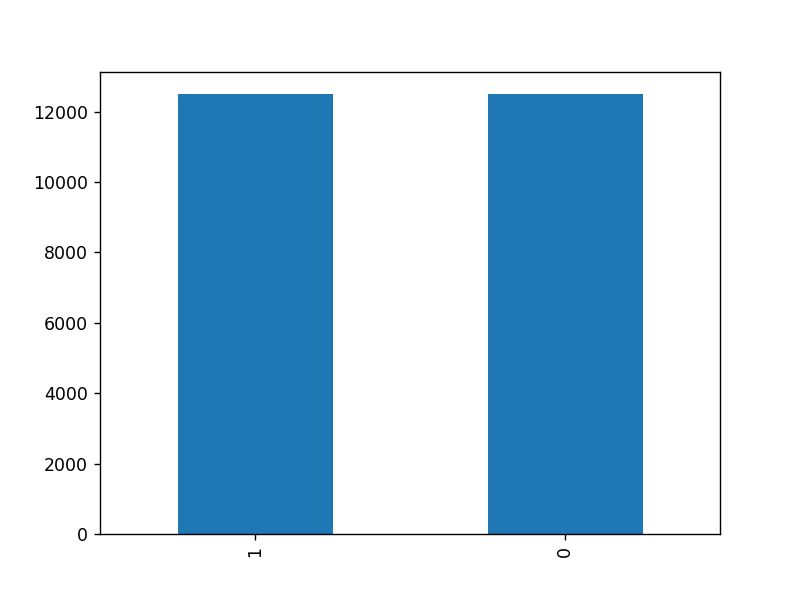

In [17]:
%matplotlib notebook
df['category'].value_counts().plot.bar()

<IPython.core.display.Javascript object>


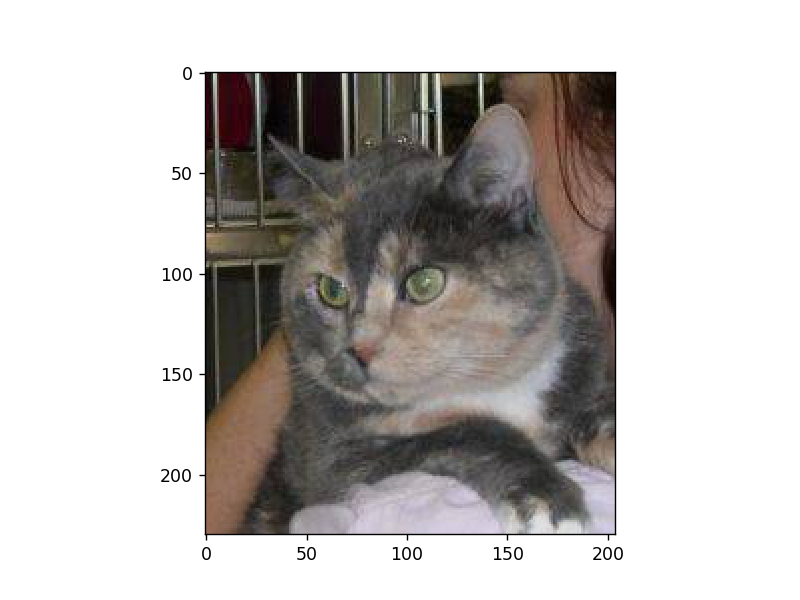

In [18]:
%matplotlib notebook
sample = random.choice(filenames)
image = load_img(path+"train/"+sample)
plt.imshow(image)

In [19]:
from keras.models import Sequential
from keras.layers import * 

In [20]:
# 레이어 1
model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH , IMAGE_CHANNEL)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 레이어 2 
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 레이어3
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
          
# Fully Connected 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2,activation="softmax"))

In [21]:
# 모델 실행 옵션 
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)       

In [22]:
# reduceLROnPlateau 
# : callback 함수의 일종, learning rate가 더이상 업데이트가 되지 않으면, 학습을 중단하여라 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_accuracy", 
                        patience = 2, 
                        factor = 0.5, 
                        min_lr=0.0001,
                        verbose=1)
                        
callbacks = [earlystop, learning_rate_reduction]

In [23]:
# 이미지 제너레이터에서 class_mode = "categorical"로 지정하기 위해 컬럼 카테고리를 스트링으로 변경함. 
df['category']=df['category'].replace({0:'cat',1:"dog"})

In [24]:
train_df, validate_df = train_test_split(df , test_size=0.2, random_state= 42)

train_df=train_df.reset_index(drop=True)
validate_df=validate_df.reset_index(drop=True)


train_df['category'].value_counts()

cat    10024
dog     9970
Name: category, dtype: int64

In [25]:
validate_df['category'].value_counts()

dog    2530
cat    2469
Name: category, dtype: int64

In [26]:
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

# 트레이닝 데이터의 제너레이터 설정 
train_datagen=ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1, 
        height_shift_range=0.1)
        
train_generator=train_datagen.flow_from_dataframe(
    train_df, 
    path+"train",
    x_col = "filename", 
    y_col = "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size )
    
validate_datagen=ImageDataGenerator(rescale=1./255)
# 검증이미지니까, 사진 그대로 쓰겠다. 

validation_generator=validate_datagen.flow_from_dataframe(
    validate_df,
    path+"train",
    x_col= "filename",
    y_col= "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size )

Found 19994 validated image filenames belonging to 2 classes.
Found 4999 validated image filenames belonging to 2 classes.


In [27]:
example_df=train_df.sample(n=1).reset_index(drop=True)
example_df

,filename,category
0,cat.6751.jpg,cat


In [28]:
example_generator = train_datagen.flow_from_dataframe(
                    example_df,
                    path+"train",
                    x_col = "filename",
                    y_col = "category",
                    target_size = IMAGE_SIZE,
                    class_mode = "categorical")

Found 1 validated image filenames belonging to 1 classes.


<IPython.core.display.Javascript object>


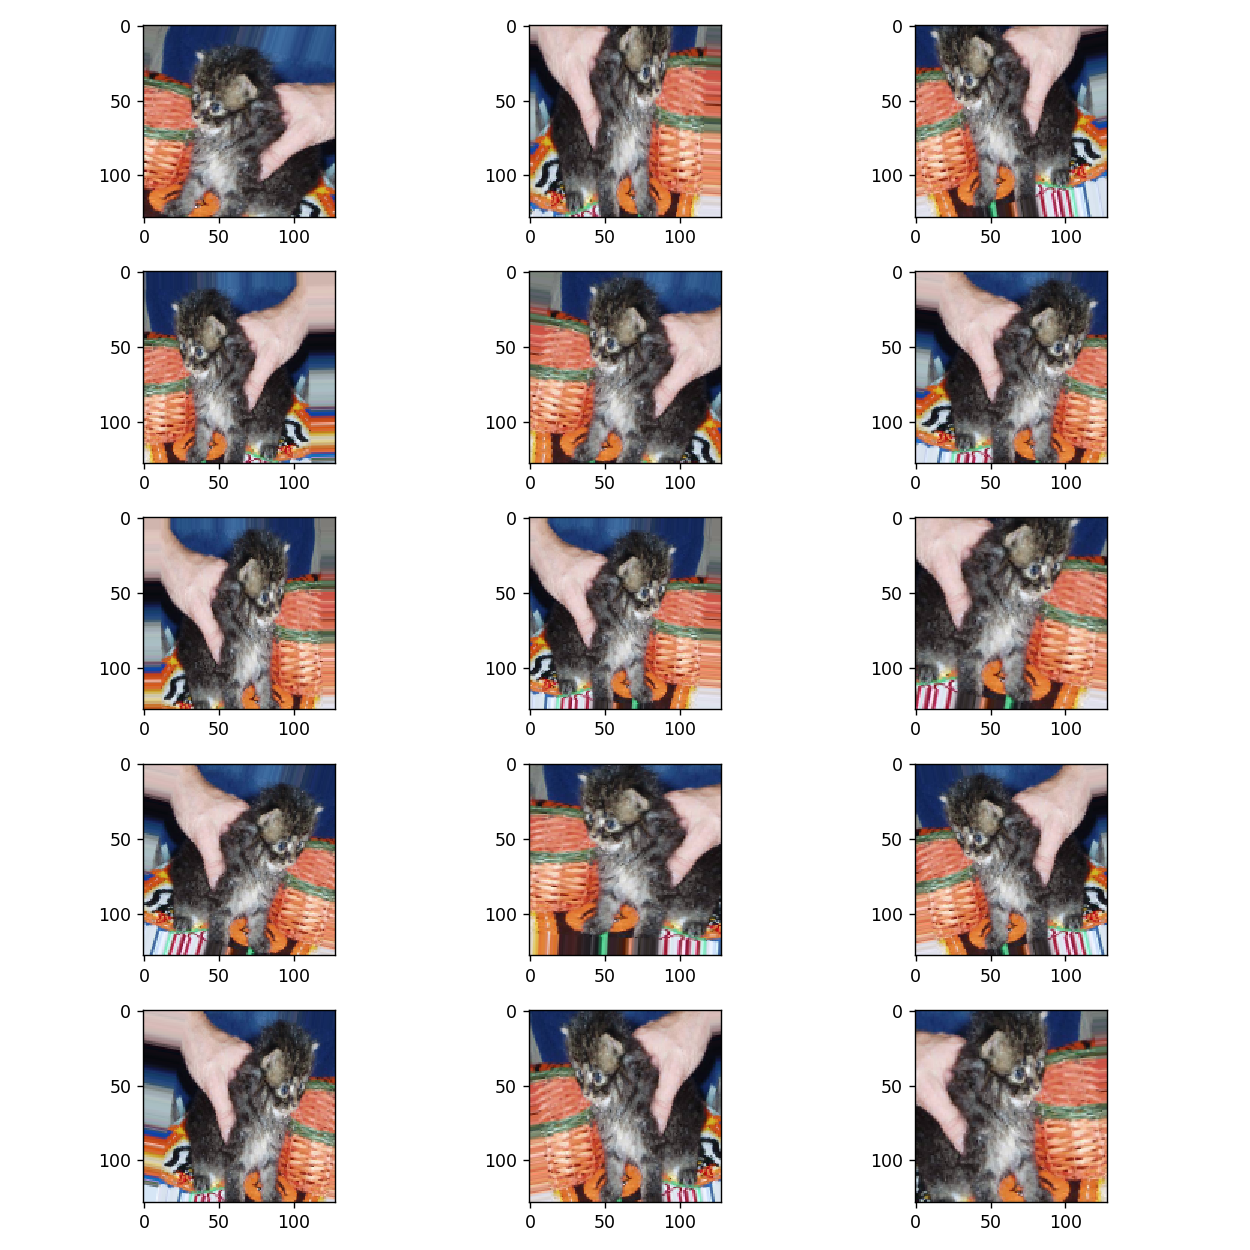

In [29]:
plt.figure(figsize=(10,10))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for xBatch, yBatch in example_generator:
        image = xBatch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [30]:
epochs = 3 

history = model.fit_generator(
    train_generator, 
    epochs = epochs, 
    steps_per_epoch = total_train//batch_size ,
    validation_data=  validation_generator,
    validation_steps = total_validate//batch_size,
    callbacks = callbacks,
)


Epoch 1/3
1332/1332 [==============================] - 374s 281ms/step - loss: 0.7354 - accuracy: 0.6396 - val_loss: 0.5458 - val_accuracy: 0.7189
Epoch 2/3
1332/1332 [==============================] - 204s 153ms/step - loss: 0.5529 - accuracy: 0.7248 - val_loss: 0.6540 - val_accuracy: 0.7111
Epoch 3/3
1332/1332 [==============================] - 203s 152ms/step - loss: 0.4950 - accuracy: 0.7641 - val_loss: 0.4811 - val_accuracy: 0.7934


In [31]:
model_json = model.to_json()
with open('CNN_dog_cat_model_V2.json','w') as json_file:
    json_file.write(model_json)

model.save_weights('CNN_dog_cat_model_V2.h5')
print('Saved model to disk')

Saved model to disk


<IPython.core.display.Javascript object>


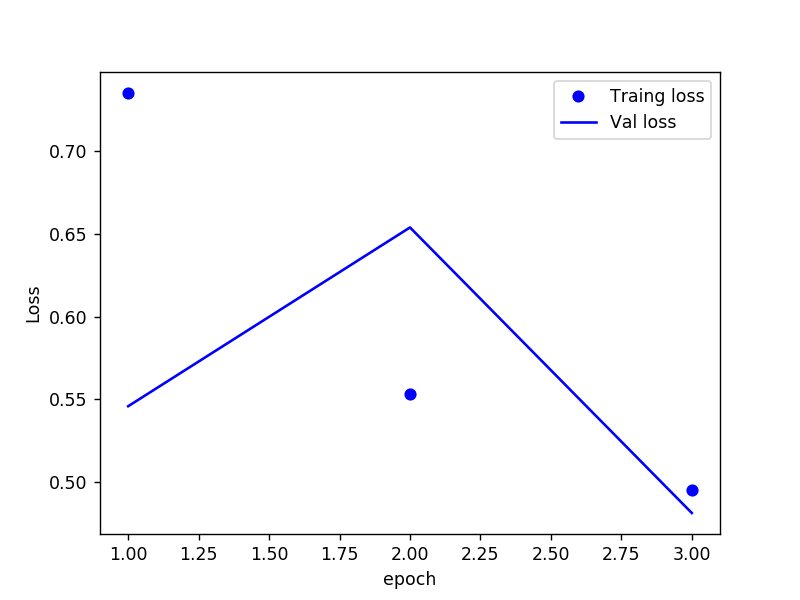

In [32]:
historyDict=history.history

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

%matplotlib notebook
epo = range(1, len(acc)+1)
plt.plot(epo, loss, 'bo', label="Traing loss")
plt.plot(epo, val_loss, 'b', label="Val loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


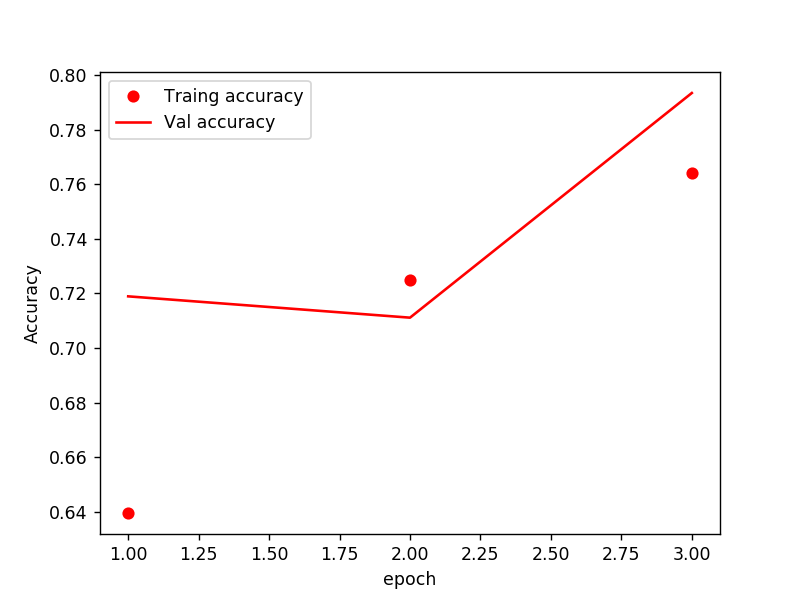

In [33]:
%matplotlib notebook

plt.plot(epo, acc, 'ro', label="Traing accuracy")
plt.plot(epo, val_acc, 'r', label="Val accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [46]:
# 테스트 데이터 준비 
filenames = os.listdir(path+"test1")

test_df=pd.DataFrame( {"filename":filenames} )      
test_df

nbsamples=test_df.shape[0]
print(nbsamples)

12500


In [47]:
test_datagen=ImageDataGenerator(rescale=1./255)
# 테스트 이미지니까, 사진 그대로 씀
test_generator=test_datagen.flow_from_dataframe(
    test_df,
    path+"test1",
    x_col= "filename",
    y_col= None,
    target_size = IMAGE_SIZE,
    class_mode = None,
    batch_size = batch_size,
    shuffle = False)

Found 12500 validated image filenames.


In [48]:
# 3. 예측 
predict=model.predict_generator(test_generator, 
                                steps=nbsamples/batch_size, 
                                callbacks=callbacks)
                                
test_df['category']=np.argmax(predict, axis=1)

In [41]:
test_df['category']=test_df['category'].replace({0:'cat',1:"dog"})
ex_df=test_df.sample(n=1).reset_index(drop=True)
ex_df

,filename,category
0,4203.jpg,dog


In [38]:
ex_generator = test_datagen.flow_from_dataframe(
                    ex_df,
                    path+"test1",
                    x_col = "filename",
                    y_col = None,
                    target_size = IMAGE_SIZE,
                    class_mode = None)

Found 1 validated image filenames.


In [39]:
test_sample=list(ex_df.filename)

sample = ""
for test in test_sample:
    sample += test

<IPython.core.display.Javascript object>


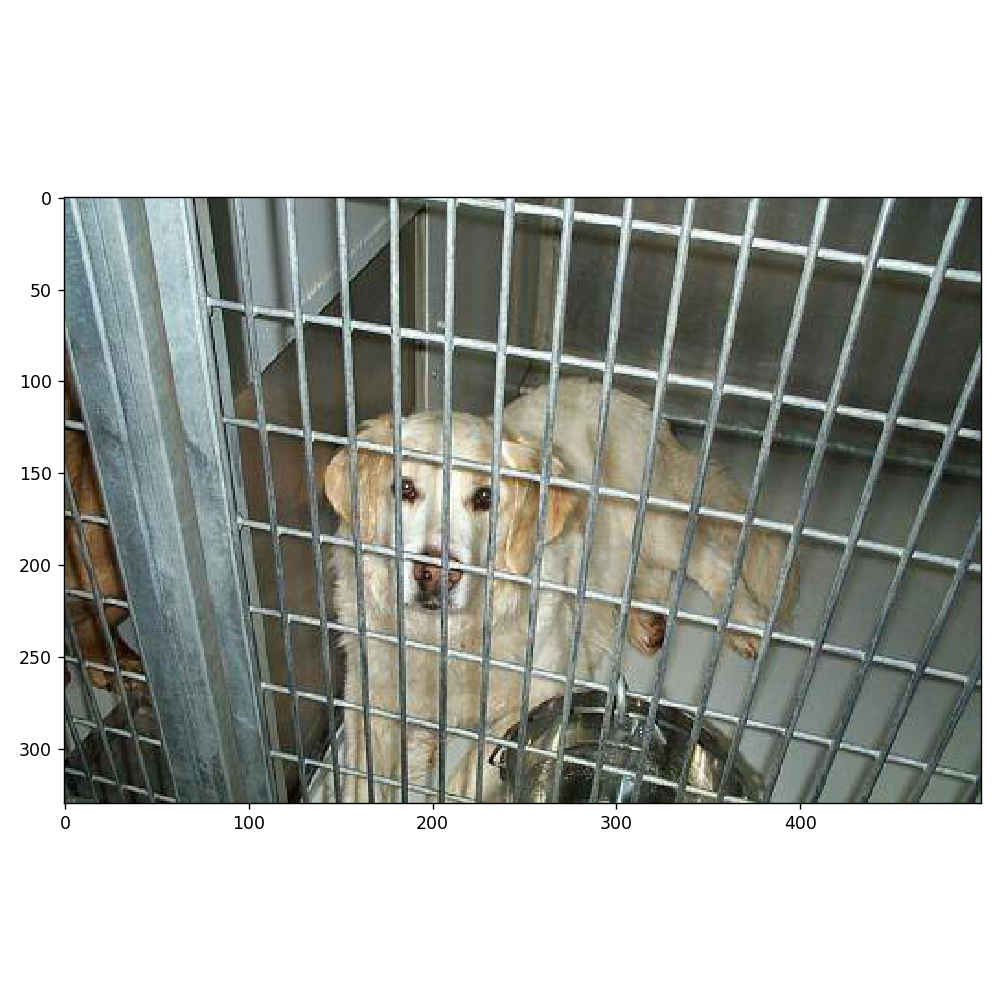

In [40]:
image = load_img(path+"test1/"+sample)
plt.figure(figsize=(8,8))
plt.imshow(image)

plt.tight_layout()
plt.show()